# NorESM at Zeppelin

In [128]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
# Importing necessary libraries and functions

import xarray as xr
from sizedist_utils import compute_Nx_ebas_cleaned
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022')

['escience2022/Ada',
 'escience2022/Antoine',
 'escience2022/Dominic',
 'escience2022/ESA_SMOS_sss',
 'escience2022/Remy',
 'escience2022/Sara',
 'escience2022/Zhihong']

## Load and prepare data

### Zeppelin station

In [130]:
# Zeppelin data

data1 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part1.nc4')
data2 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part2.nc4')

In [131]:
# Wave your cloud flag

data1_cl_mask=data1.where(data1['cloud_flag']=='yes')
data1_no_cl = data1.where(data1['cloud_flag']=='no')

In [132]:
data1

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/17)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 ...
    cloud_flag                                     (time) object 'yes' ... 'no'
    enrichment_factor                              (time) float64 ...
    transmission_efficiency_factor                 (time) float64 ...
    cluster                                        (time) float64 ...
    ...                                             ...
    temperature                                    (time) float64 ...
    wind_direction                                 (time) float64 ...
    wind_speed                                     (time) float64 ...
    updraft_velocity                               (time) float64 ...
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

### NorESM data

In [6]:
# Pick variables

varl = ['N100','N200','N50'] 

In [7]:
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

In [8]:
def make_file_path_for_var(v,):
    return path_to_data+v+postfix

In [9]:
filelist = [make_file_path_for_var(v) for v in varl]

In [10]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds = xr.open_mfdataset(list_of_s3_obj)

ds

<xarray.Dataset>
Dimensions:   (lev: 32, time: 26352, location: 5)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time      (time) datetime64[ns] 2015-01-01 ... 2018-01-02T23:00:00
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
Data variables:
    N100      (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    N200      (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    N50       (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>

In [11]:
ds.sel(location='Zeppelin').time

<xarray.DataArray 'time' (time: 26352)>
array(['2015-01-01T00:00:00.000000000', '2015-01-01T01:00:00.000000000',
       '2015-01-01T02:00:00.000000000', ..., '2018-01-02T21:00:00.000000000',
       '2018-01-02T22:00:00.000000000', '2018-01-02T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2015-01-01 ... 2018-01-02T23:00:00
    location  <U8 'Zeppelin'
Attributes:
    long_name:  time
    bounds:     time_bnds

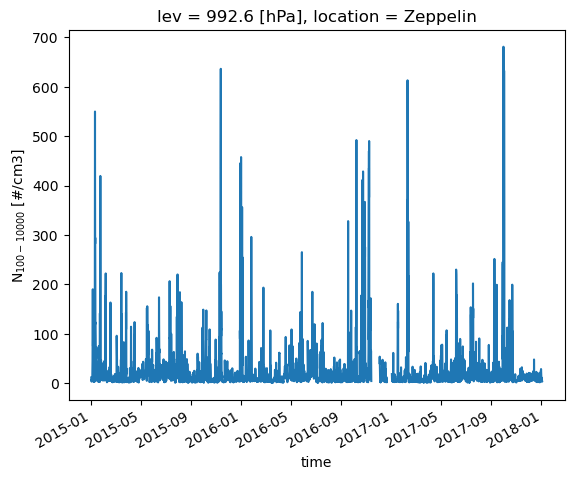

In [12]:
Nx_NorESM_N100_srf=ds.isel(lev=-1).sel(location='Zeppelin')['N100'].plot()

In [30]:
#dss = ds.sel(time = slice('1990-01-01','2010-01-01'))

#Nx_NorESM_N100_srf_Ztime=Nx_NorESM_N100_srf.resample(time='M').mean()#.sel(time = slice('

### NorESM cloud properties

In [166]:
varl = ['AWNC', 'AREL', 'FREQL', 'N100','N50'] 

In [167]:
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

In [168]:
def make_file_path_for_var(v,):
    return path_to_data+v+postfix

In [169]:
filelist = [make_file_path_for_var(v) for v in varl]

In [170]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds = xr.open_mfdataset(list_of_s3_obj)

ds

<xarray.Dataset>
Dimensions:   (lev: 32, time: 26352, location: 5)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time      (time) datetime64[ns] 2015-01-01 ... 2018-01-02T23:00:00
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
Data variables:
    AREL      (location, time, lev) float32 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    AWNC      (location, time, lev) float32 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    FREQL     (location, time, lev) float32 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    N100      (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    N50       (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>

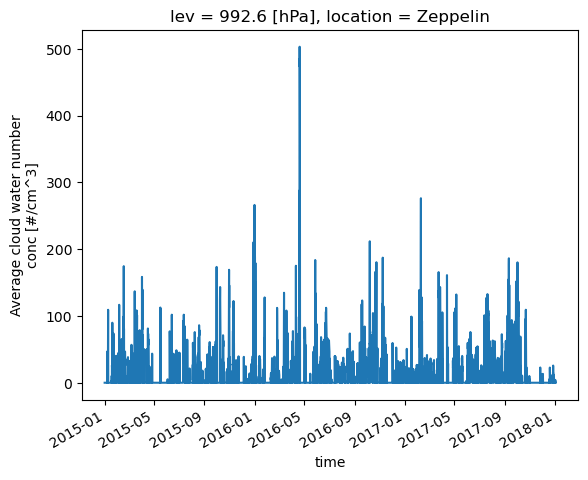

In [18]:
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC'].plot()

## Zeppelin droplet number concentration

In [19]:
data1_cl_mask

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/17)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 29.39 ... nan
    cloud_flag                                     (time) object 'yes' ... nan
    enrichment_factor                              (time) float64 10.82 ... nan
    transmission_efficiency_factor                 (time) float64 2.796 ... nan
    cluster                                        (time) float64 2.0 ... nan
    ...                                             ...
    temperature                                    (time) float64 -6.659 ... nan
    wind_direction                                 (time) float64 130.2 ... nan
    wind_speed                                     (time) float64 9.748 ... nan
    updraft_velocity                               (time) float64 4.506 ... nan
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

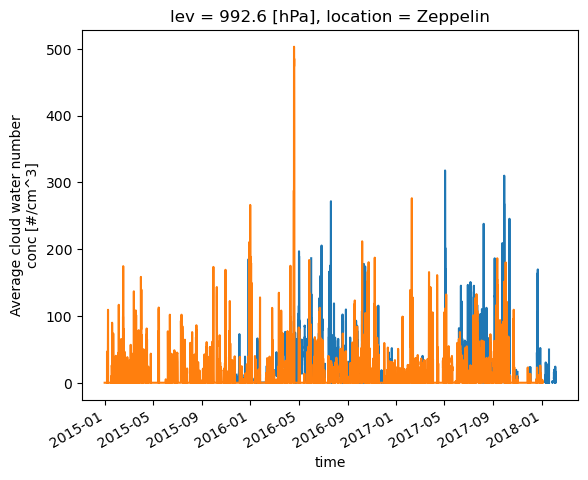

In [20]:
# Cloud droplet number concentration, with cloud particle size distribution from Fog monitor

Nx_cloud =compute_Nx_ebas_cleaned(data1_cl_mask,x=1e-9, var_diam = 'cloud_diameters', v_dNdlog10D='cloud_particle_size_distribution')
Nx_cloud.plot()
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC'].plot()

## Histogram: Cloud droplet number, different levels

In [171]:
ds['AWNC_incld'] = ds['AWNC']/ds['FREQL']

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 400)

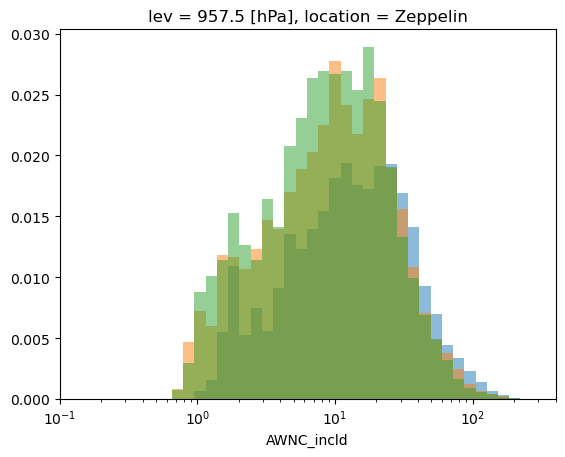

In [22]:
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
ds.isel(lev=-2).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3, 50), alpha=.5, density = True)
ds.isel(lev=-3).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5 , density = True)
plt.xscale('log')
plt.xlim([0.1,400])

## Histogram: droplet number, zeppelin vs NorESM

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 400)

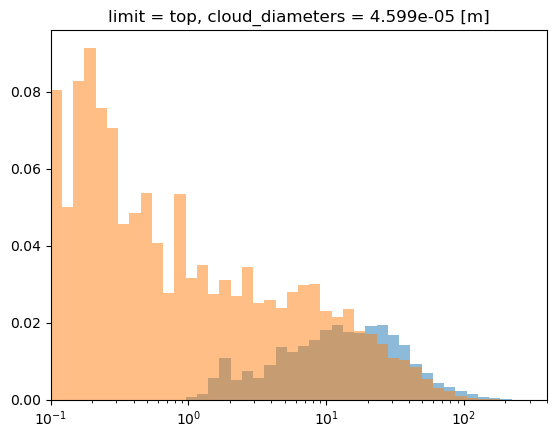

In [23]:
#resampling obs to hourly data
Nx_cloud_hourly=Nx_cloud.resample(time='H').mean()


#Plotting histograms of NorESM incloud droplet number and cloudmasked fogmonitor droplet number
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
Nx_cloud_hourly.plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
plt.xscale('log')
plt.xlim([0.1,400])

### Icefree clouds

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 400)

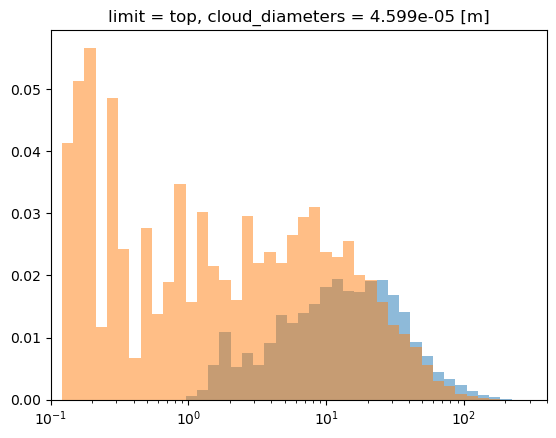

In [24]:
# Select where T > -4 from measurements, to remove ice
Nx_cloud_icefree=Nx_cloud.where(data1['temperature'] > -4.0)
Nx_cloud_icefree_hourly = Nx_cloud_icefree.resample(time='H').mean()

#Plotting histograms of NorESM incloud droplet number and cloudmasked fogmonitor droplet number
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
Nx_cloud_icefree_hourly.plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
plt.xscale('log')
plt.xlim([0.1,400])

## Explanation for many measurements at low concentration with the fog monitor: it includes measurements where the particle concentration is high, but the LWC is low, so these are not droplets, just aerosols.

### Cloud residual particles

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 400)

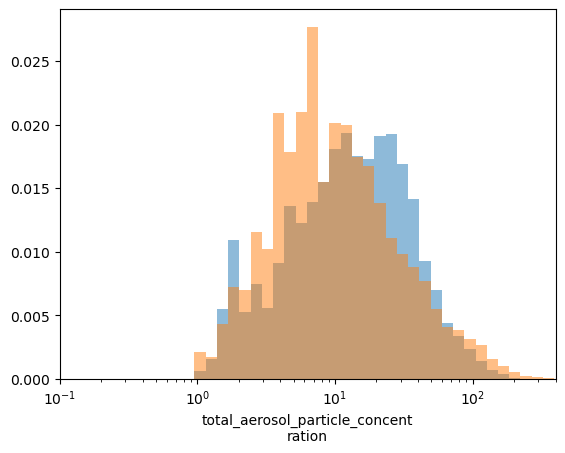

In [25]:
Nx_cloudresidual=data1_cl_mask.total_aerosol_particle_concentration

#resampling obs to hourly data
Nx_cloudresidual_hourly=Nx_cloudresidual.resample(time='H').mean()



#Plotting histograms of NorESM incloud droplet number and cloudmasked fogmonitor droplet number
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
Nx_cloudresidual_hourly.plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
plt.xscale('log')
plt.xlim([0.1,400])

## Seasons

### NorESM

In [26]:
ds_seasons = ds.groupby('time.season')

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 400)

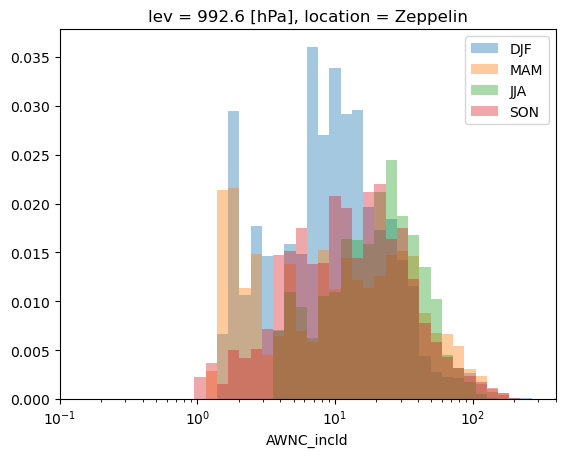

In [27]:
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    ds_seasons[s].isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(density=True,alpha=0.4, bins=np.logspace(-1,3,50), label=s)
    
plt.legend()

plt.xscale('log')
plt.xlim([0.1,400])

### Cloud residual

In [28]:
Nx_cloudresidual_seasons = Nx_cloudresidual_hourly.groupby('time.season')

(0.1, 400)

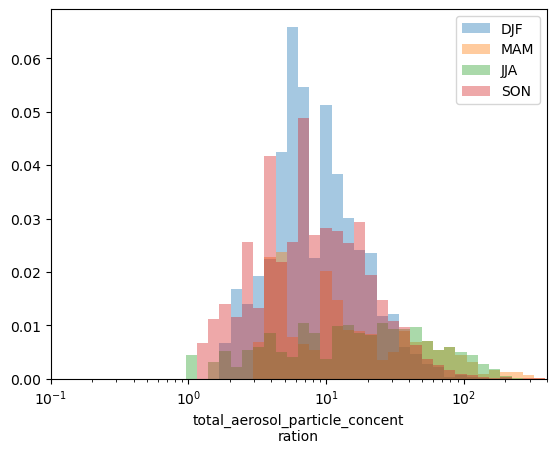

In [29]:
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    Nx_cloudresidual_seasons[s].plot.hist(density=True,alpha=0.4, bins=np.logspace(-1,3,50), label=s)
    
plt.legend()

plt.xscale('log')
plt.xlim([0.1,400])

### (icefree) Cloud droplets from fog monitor

In [30]:
Nx_cloud_icefree_seasons = Nx_cloud_icefree_hourly.groupby('time.season')

(0.1, 400)

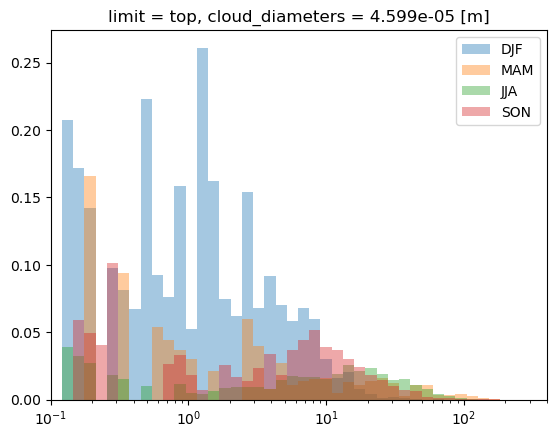

In [31]:
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    Nx_cloud_icefree_seasons[s].plot.hist(density=True,alpha=0.4, bins=np.logspace(-1,3,50), label=s)
    
plt.legend()

plt.xscale('log')
plt.xlim([0.1,400])

# Histogram subplots in seasons

In [32]:
# Load droplet number data from NorESM, GSVI and fog monitor

Nx_cloudresidual_seasons = Nx_cloudresidual_hourly.groupby('time.season')
ds_seasons = ds.groupby('time.season')
Nx_cloud_icefree_seasons = Nx_cloud_icefree_hourly.groupby('time.season')

season_str=['DJF', 'MAM', 'JJA', 'SON']


### Try to make a nice plot with Theos tutorial

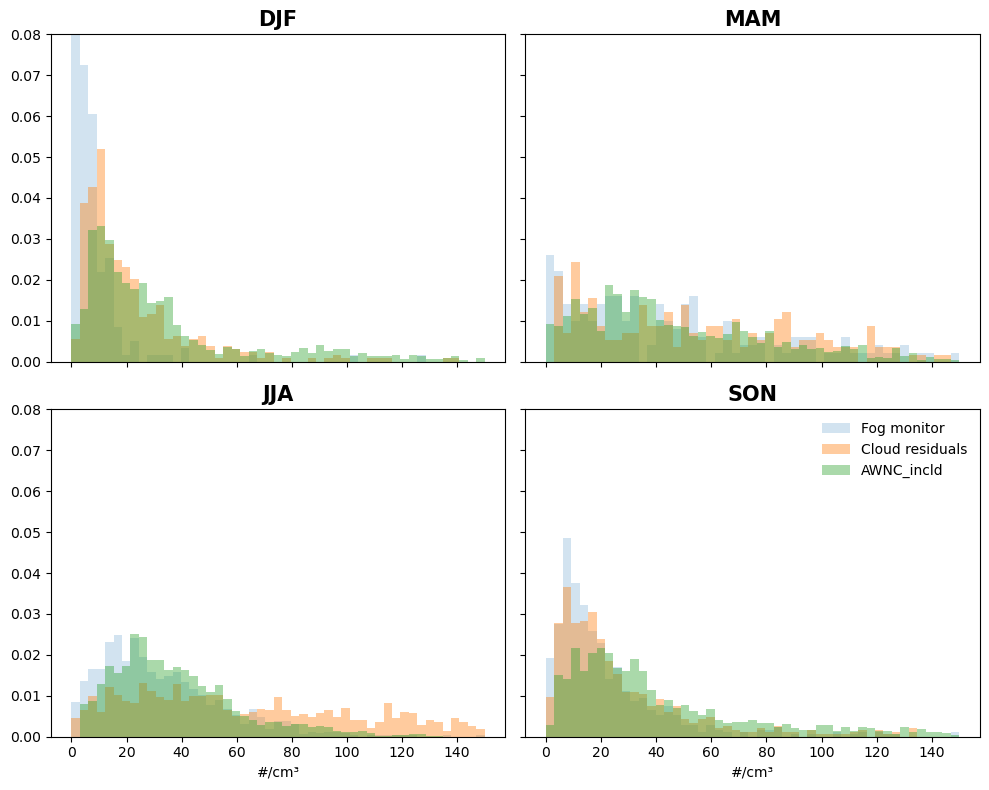

In [46]:
# define a figure and choose the size
#fig = plt.figure(figsize=(10, 8))

fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 8))

# create the grid using plt.subplots
# nrows = 3, ncols = 4
for n_ax, ax in zip(range(0, 4), axs.flatten()):
    #ax = plt.subplot(2, 2, n_ax + 1)
    
    
    #hide_ticks(ax)
    
    Nx_cloud_icefree_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.2, bins=np.linspace(0,150,50), label='Fog monitor', ax = ax )
    Nx_cloudresidual_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.4, bins=np.linspace(0,150,50), label='Cloud residuals', ax = ax)
    ds_seasons[season_str[n_ax]].isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(density=True,alpha=0.4, bins=np.linspace(0,150,50), ax= ax,
                                                                                               label='AWNC_incld')
    if n_ax==3:
        ax.legend(frameon=False)
    #plt.xscale('log')
    #plt.xlim([0.1,400])
    if n_ax>=2:
        ax.set_xlabel('#/cm³')
    else:
        ax.set_xlabel('')
    plt.ylim([0,0.08])
    ax.set_title(season_str[n_ax], fontweight='bold', fontsize=15)
    #bins=np.logspace(-1,3,50)
# adjust the spacing between subplots: wspace for width and hspace for height
plt.tight_layout()
#plt.subplots_adjust(wspace=0.2, hspace=0.2)

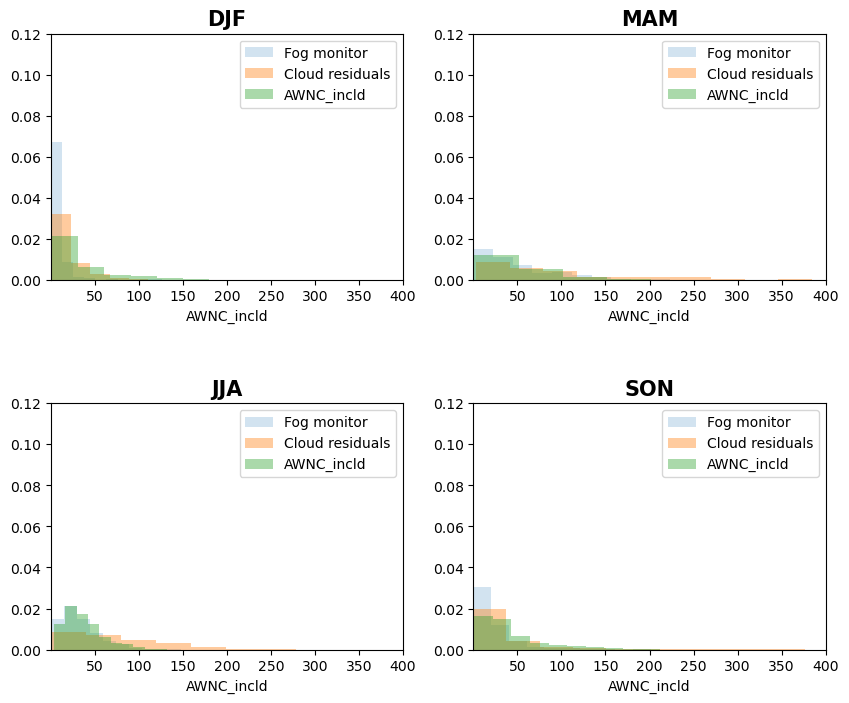

In [60]:
# define a figure and choose the size
fig = plt.figure(figsize=(10, 8))

# create the grid using plt.subplots
# nrows = 3, ncols = 4
for n_ax in range(0, 4):
    ax = plt.subplot(2, 2, n_ax + 1)
    
    #hide_ticks(ax)
    
    Nx_cloud_icefree_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.2, label='Fog monitor')
    Nx_cloudresidual_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.4,  label='Cloud residuals')
    ds_seasons[season_str[n_ax]].isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(density=True,alpha=0.4,  label='AWNC_incld')
    
    plt.legend()
    #plt.xscale('log')
    plt.xlim([0.1,400])
    plt.ylim([0,0.12])
    ax.set_title(season_str[n_ax], fontweight='bold', fontsize=15)

# adjust the spacing between subplots: wspace for width and hspace for height
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [139]:
data1

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/17)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 29.39 ... 2...
    cloud_flag                                     (time) object 'yes' ... 'no'
    enrichment_factor                              (time) float64 10.82 ... 1.0
    transmission_efficiency_factor                 (time) float64 2.796 ... nan
    cluster                                        (time) float64 2.0 ... nan
    ...                                             ...
    temperature                                    (time) float64 -6.659 ... ...
    wind_direction                                 (time) float64 130.2 ... 1...
    wind_speed                                     (time) float64 9.748 ... 1...
    updraft_velocity                               (time) float64 4.506 ... 4...
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

# Scatter plots: N100 --> droplet concentration

In [237]:
# Calculate N100 and N50 from all_air inlet (data2) aerosol particle size distribution, by integrating above 100 and 50

N100_allair=compute_Nx_ebas_cleaned(data1_cl_mask,x=100e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')
N50_allair=compute_Nx_ebas_cleaned(data1_cl_mask,x=50e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')
N25_allair=compute_Nx_ebas_cleaned(data1_cl_mask,x=25e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')

In [238]:
# Make daily means 

N100_allair_daily = N100_allair.resample(time='D').mean()
N50_allair_daily = N50_allair.resample(time='D').mean()
N25_allair_daily = N50_allair.resample(time='D').mean()
Nx_cloud_daily = Nx_cloud.resample(time='D').mean()
Nx_cloudresidual_daily = Nx_cloudresidual.resample(time='D').mean()
ds_daily = ds.resample(time='D').mean()


/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis,

In [239]:
# Merging obs. variables to get droplet number and particle number in one

N100_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N100_allair_daily.rename('N100_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])
N50_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N50_allair_daily.rename('N50_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])
N25_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N25_allair_daily.rename('N25_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])

#Extracting time series common for obs and model: 2015-11-27 - 2018-01-02

N100_daily.sel(time=slice('2015-11-27','2018-01-02'))
N50_daily.sel(time=slice('2015-11-27','2018-01-02'))
N25_daily.sel(time=slice('2015-11-27','2018-01-02'))
ds_daily.sel(time=slice('2015-11-27','2018-01-02'))


<xarray.Dataset>
Dimensions:     (location: 5, time: 768, lev: 32)
Coordinates:
  * lev         (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * location    (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
  * time        (time) datetime64[ns] 2015-11-27 2015-11-28 ... 2018-01-02
Data variables:
    AREL        (location, time, lev) float32 dask.array<chunksize=(5, 768, 32), meta=np.ndarray>
    AWNC        (location, time, lev) float32 dask.array<chunksize=(5, 768, 32), meta=np.ndarray>
    FREQL       (location, time, lev) float32 dask.array<chunksize=(5, 768, 32), meta=np.ndarray>
    N100        (location, time, lev) float64 dask.array<chunksize=(5, 768, 32), meta=np.ndarray>
    N50         (location, time, lev) float64 dask.array<chunksize=(5, 768, 32), meta=np.ndarray>
    AWNC_incld  (location, time, lev) float32 dask.array<chunksize=(5, 768, 32), meta=np.ndarray>

In [156]:
N100_daily_nonan=N100_daily.dropna('time')

model = LinearRegression().fit(N100_daily_nonan.N100_allair.data.reshape(-1,1), N100_daily_nonan.Nx_cloud)
rs=model.score(N100_daily_nonan.N100_allair.data.reshape(-1,1), N100_daily_nonan.Nx_cloud)
rs

0.49640575338095505

In [92]:
N50_daily_nonan=N50_daily.dropna('time')

model = LinearRegression().fit(N50_daily_nonan.N50_allair.data.reshape(-1,1), N50_daily_nonan.Nx_cloud)
rs=model.score(N50_daily_nonan.N50_allair.data.reshape(-1,1), N50_daily_nonan.Nx_cloud)
rs

0.5520286300212757

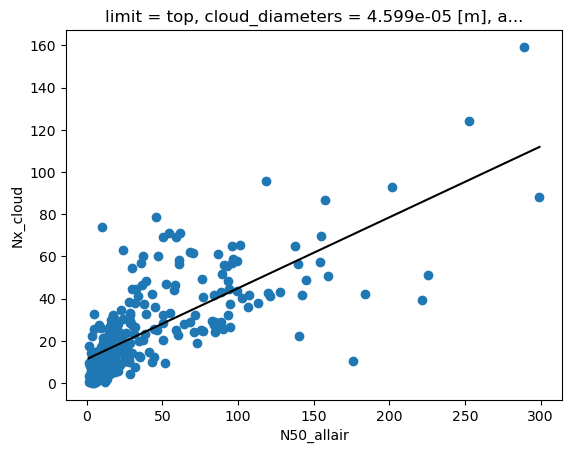

In [274]:
N50_daily.plot.scatter('N50_allair','Nx_cloud')
z = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloud'],1)
p = np.poly1d(z)
x=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
plt.plot(x, p(x), c='k')
#plt.xscale('log')
#plt.yscale('log')

In [227]:
ds_nonan.AWNC_incld.data.reshape(-1,1)

dask.array<reshape, shape=(612, 1), dtype=float32, chunksize=(612, 1), chunktype=numpy.ndarray>

In [241]:
N100_daily_nonan=N100_daily.dropna('time')
N50_daily_nonan= N50_daily.dropna('time')
N25_daily_nonan= N25_daily.dropna('time')
ds_nonan = ds_daily.isel(lev=-1).sel(location='Zeppelin').dropna('time')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [228]:
model_rs_N100_cloud = LinearRegression().fit(N100_daily_nonan.N100_allair.data.reshape(-1,1), N100_daily_nonan.Nx_cloud)
rs_N100_cloud=model.score(N100_daily_nonan.N100_allair.data.reshape(-1,1), N100_daily_nonan.Nx_cloud)
print('rs_N100_cloud: ', rs_N100_cloud)


model_rs_N100_cloudresidual = LinearRegression().fit(N100_daily_nonan.N100_allair.data.reshape(-1,1), N100_daily_nonan.Nx_cloudresidual)
rs_N100_cloudresidual=model.score(N100_daily_nonan.N100_allair.data.reshape(-1,1), N100_daily_nonan.Nx_cloudresidual)
print('rs_N100_cloudresidual: ', rs_N100_cloudresidual)


model_rs_N100_AWNC = LinearRegression().fit(ds_nonan.N100.data.reshape(-1,1), ds_nonan.AWNC_incld.data)
rs_N100_AWNC=model.score(ds_nonan.N100.data.reshape(-1,1), ds_nonan.AWNC_incld.data)
print('rs_N100_AWNC: ', rs_N100_AWNC)

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


rs_N100_cloud:  0.49640575338095505
rs_N100_cloudresidual:  0.2054714012863712


/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


rs_N100_AWNC:  0.04124190935420913


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


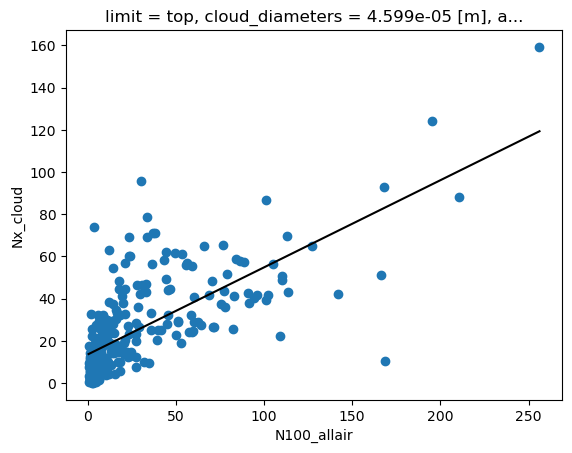

In [69]:
N100_daily.plot.scatter('N100_allair','Nx_cloud')
z = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloud'],1)
p = np.poly1d(z)
x=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
plt.plot(x, p(x), c='k')
#plt.xscale('log')
#plt.yscale('log')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


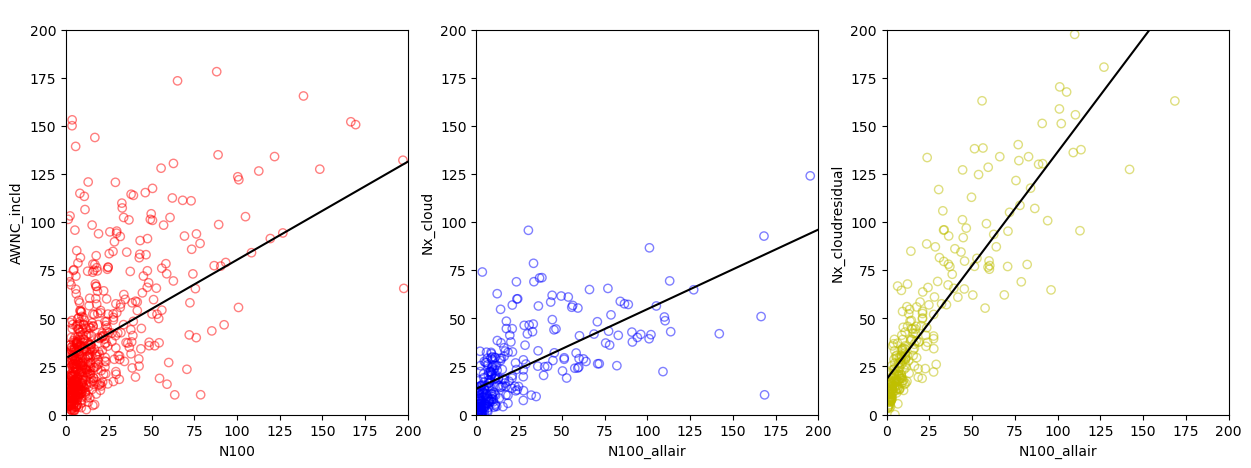

In [234]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

#-------------------------------------------------------------------
ds_nonan.plot.scatter('N100', 'AWNC_incld', alpha=.5, edgecolor='r',facecolor='None', marker='o', ax = axs[0])

z0 = np.polyfit(ds_nonan['N100'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N100'].min(), ds_nonan['N100'].max())
axs[0].plot(x0, p0(x0), c='k')

#-------------------------------------------------------------------
N100_daily_nonan.plot.scatter('N100_allair', 'Nx_cloud', alpha=.5, edgecolor='b',facecolor='None', marker='o', ax=axs[1])

z1 = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
axs[1].plot(x1, p1(x1), c='k')


#-----------------------------------------------------------------------
N100_daily_nonan.plot.scatter('N100_allair', 'Nx_cloudresidual', alpha=.5, edgecolor='y',facecolor='None', marker='o', ax=axs[2])

z2 = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
axs[2].plot(x2, p2(x2), c='k')




for ax in axs:
    ax.set_xlim([0,200])
    ax.set_ylim([0,200])
    ax.set_title(' ')


    

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


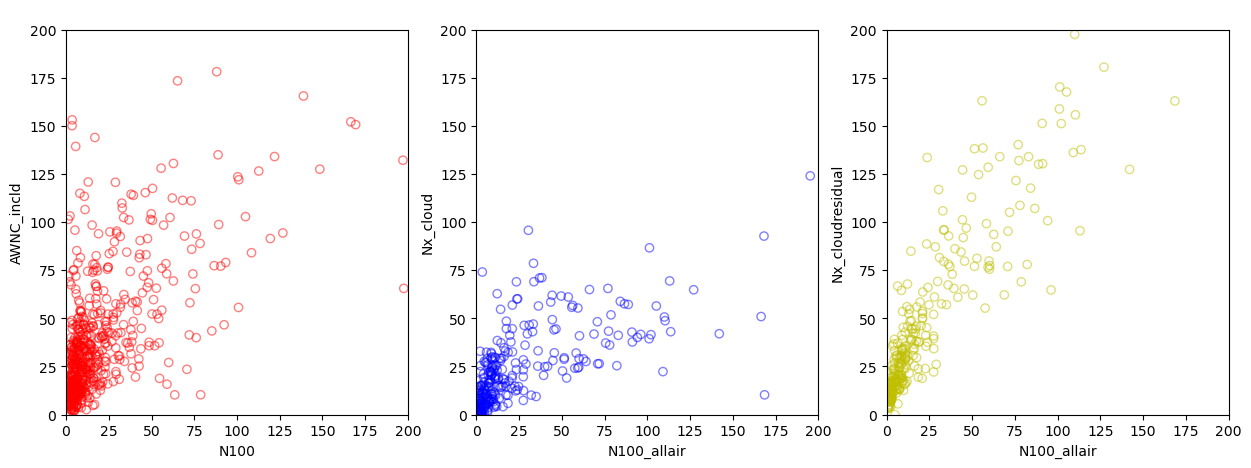

In [217]:
fig, axs = plt.subplots(1,3, figsize=(15,5))


ds_daily.isel(lev=-1).sel(location='Zeppelin').plot.scatter('N100', 'AWNC_incld', alpha=.5, edgecolor='r',facecolor='None', marker='o', ax = axs[0])

N100_daily.plot.scatter('N100_allair', 'Nx_cloud', alpha=.5, edgecolor='b',facecolor='None', marker='o', ax=axs[1])

N100_daily.plot.scatter('N100_allair', 'Nx_cloudresidual', alpha=.5, edgecolor='y',facecolor='None', marker='o', ax=axs[2])




for ax in axs:
    ax.set_xlim([0,200])
    ax.set_ylim([0,200])
    ax.set_title(' ')


    

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


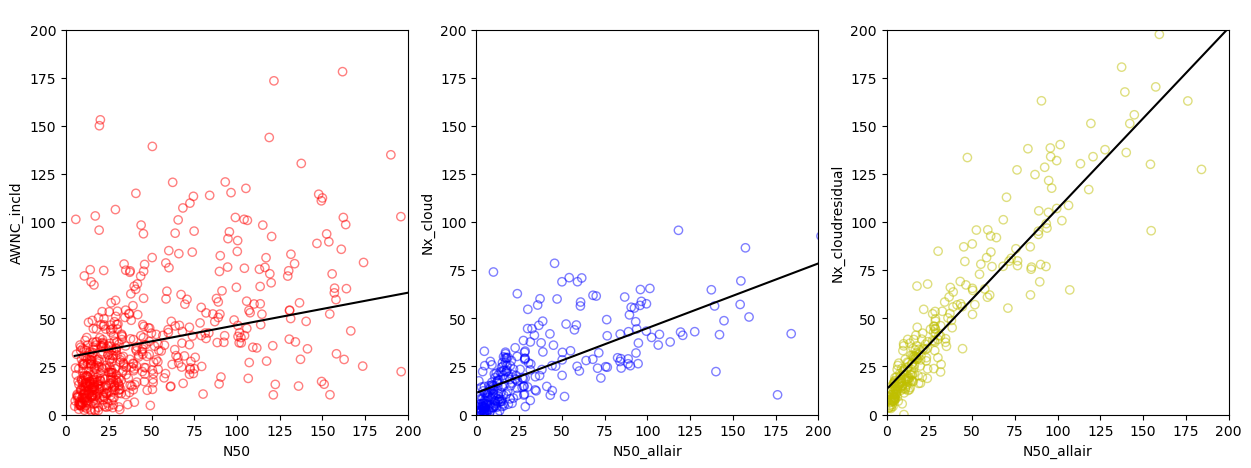

In [236]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

#------------------------------------------------------------
ds_daily.isel(lev=-1).sel(location='Zeppelin').plot.scatter('N50', 'AWNC_incld', alpha=.5, edgecolor='r',facecolor='None', marker='o', ax = axs[0])


z0 = np.polyfit(ds_nonan['N50'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N50'].min(), ds_nonan['N50'].max())
axs[0].plot(x0, p0(x0), c='k')


#-------------------------------------------------------------
N50_daily.plot.scatter('N50_allair', 'Nx_cloud', alpha=.5, edgecolor='b',facecolor='None', marker='o', ax=axs[1])

z1 = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
axs[1].plot(x1, p1(x1), c='k')



#--------------------------------------------------------------
N50_daily.plot.scatter('N50_allair', 'Nx_cloudresidual', alpha=.5, edgecolor='y',facecolor='None', marker='o', ax=axs[2])

z2 = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
axs[2].plot(x2, p2(x2), c='k')




for ax in axs:
    ax.set_xlim([0,200])
    ax.set_ylim([0,200])
    ax.set_title(' ')
    
 

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


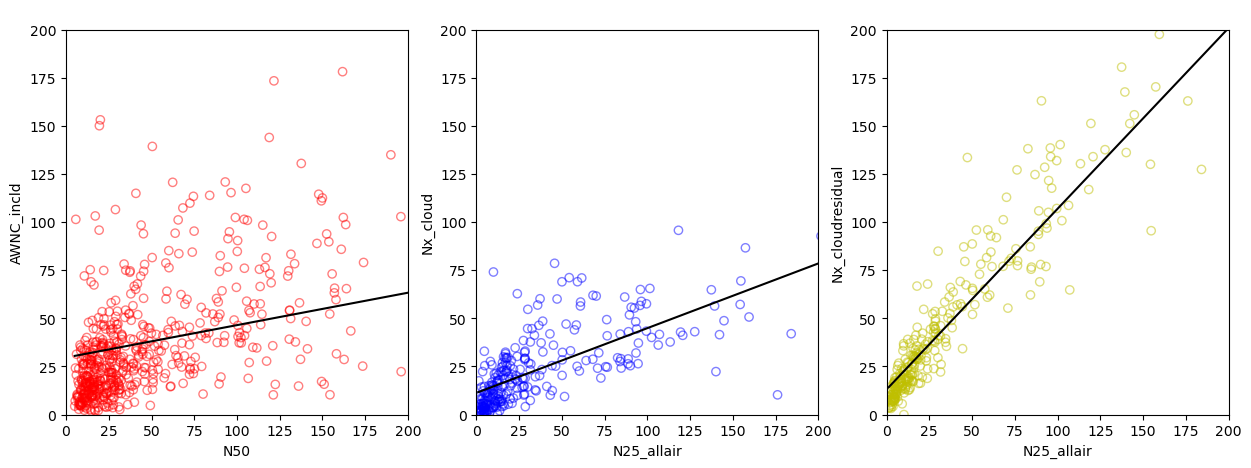

In [242]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

#-------------------------------------------------------------------
ds_nonan.plot.scatter('N50', 'AWNC_incld', alpha=.5, edgecolor='r',facecolor='None', marker='o', ax = axs[0])

z0 = np.polyfit(ds_nonan['N50'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N50'].min(), ds_nonan['N50'].max())
axs[0].plot(x0, p0(x0), c='k')

#-------------------------------------------------------------------
N25_daily_nonan.plot.scatter('N25_allair', 'Nx_cloud', alpha=.5, edgecolor='b',facecolor='None', marker='o', ax=axs[1])

z1 = np.polyfit(N25_daily_nonan['N25_allair'], N25_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N25_daily_nonan['N25_allair'].min(), N25_daily_nonan['N25_allair'].max())
axs[1].plot(x1, p1(x1), c='k')


#-----------------------------------------------------------------------
N25_daily_nonan.plot.scatter('N25_allair', 'Nx_cloudresidual', alpha=.5, edgecolor='y',facecolor='None', marker='o', ax=axs[2])

z2 = np.polyfit(N25_daily_nonan['N25_allair'], N25_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N25_daily_nonan['N25_allair'].min(), N25_daily_nonan['N25_allair'].max())
axs[2].plot(x2, p2(x2), c='k')




for ax in axs:
    ax.set_xlim([0,200])
    ax.set_ylim([0,200])
    ax.set_title(' ')



(0.0, 200.0)

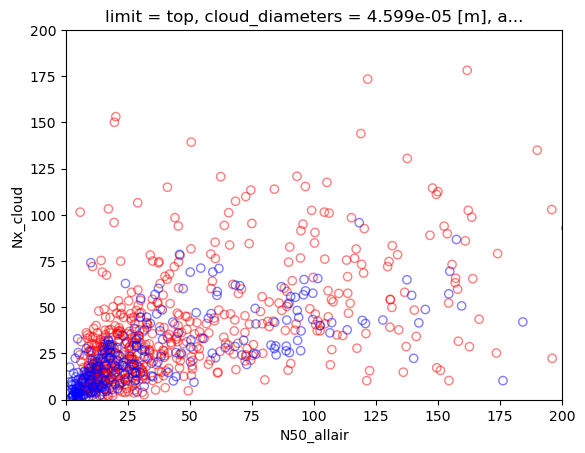

In [65]:
ds_daily.isel(lev=-1).sel(location='Zeppelin').plot.scatter('N50', 'AWNC_incld', alpha=.5, edgecolor='r',facecolor='None', marker='o')

N50_daily.plot.scatter('N50_allair', 'Nx_cloud', alpha=.5, edgecolor='b',facecolor='None', marker='o')
plt.xlim([0,200])
plt.ylim([0,200])